# BTC ML/DL Trading strategy

In [35]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [36]:
from src.Utils import *

## Preliminary data import & handling

In [37]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [38]:
# Deepcopying
df_ = df.copy(deep=True)

In [40]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [41]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="ffill", inplace=True)

In [42]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [43]:
# Some statistical analysis
df.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.00000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.576513,18706.849749,18780.56934,18636.490999,18706.957875,89.569992,18706.905950
std,1279.366497,17863.740695,17904.31739,17814.076681,17863.725874,114.678819,17863.725563
min,1.000000,3153.860000,3232.60000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.00000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.00000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.00000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.20000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [44]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [45]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

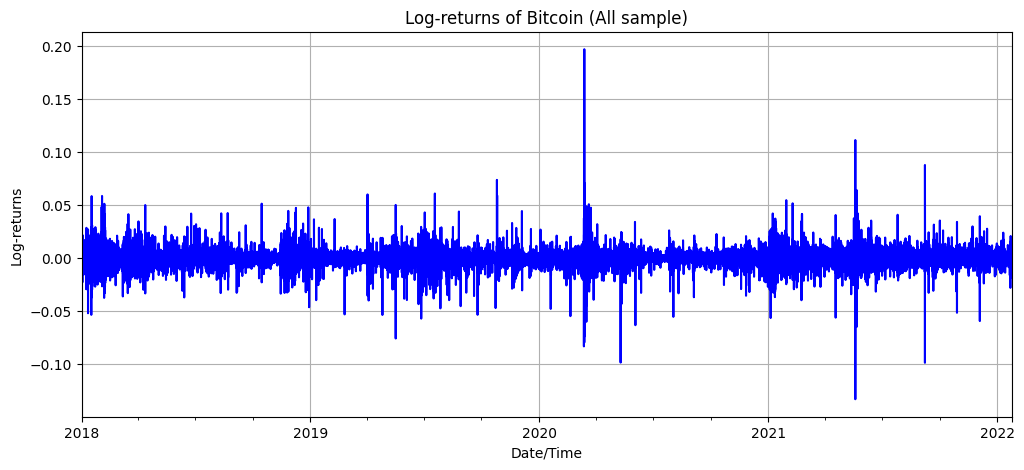

In [46]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

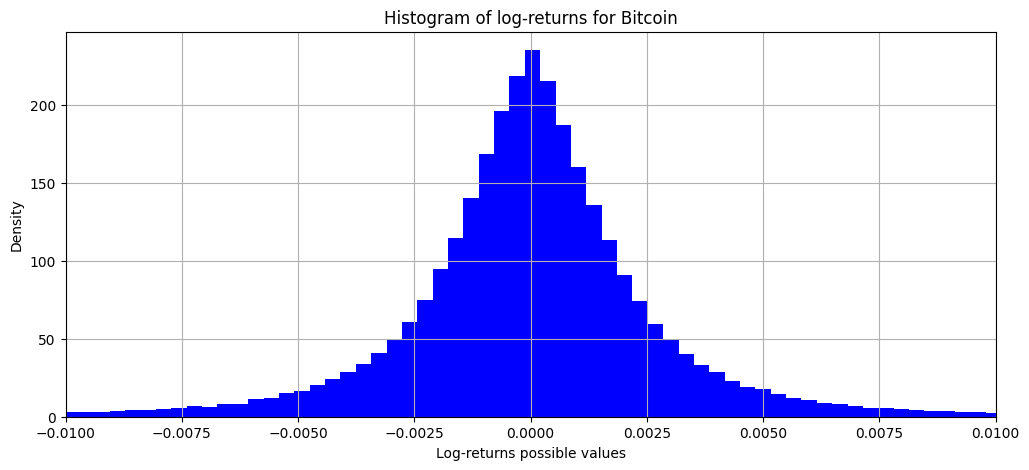

In [47]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [52]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [53]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
                                          nbdevup=2,
                                          nbdevdn=2,
                                          timeperiod=20)
df["BBANDS_U"] = upper_2sd
df["BBANDS_M"] = mid_2sd
df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

In [54]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

19

In [55]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00,340.5,13583.240,14000.0,13473.08,13715.620,54.654752,13681.354901,0,0.009870,13599.8554,-0.060853,2.326,28.744,67.990751,13698.735317,13569.1861,13439.636883,13590.7012,13599.8554,13573.468933
2018-01-01 06:30:00,209.5,13719.510,14000.0,13602.53,13718.398,24.363162,13709.096355,0,0.000203,13606.3890,0.363621,3.890,136.270,68.224229,13722.145012,13577.9101,13433.675188,13621.4800,13606.3890,13590.533867
2018-01-01 06:40:00,260.0,13718.238,14442.9,13644.99,13801.032,49.739558,13780.980585,0,0.006006,13626.5822,0.665895,-0.160,-1.272,74.396604,13759.686806,13586.5811,13413.475394,13670.9508,13626.5822,13616.111600
2018-01-01 06:50:00,278.5,13801.034,14141.0,13713.26,13868.724,54.396066,13859.155262,0,0.004893,13649.8356,0.881893,0.002,82.796,78.243280,13813.613911,13601.8327,13390.051489,13736.9376,13649.8356,13638.266533
2018-01-01 07:00:00,296.0,13865.944,14224.0,13738.98,13917.490,26.822479,13888.212163,0,0.003510,13681.1194,0.941397,-2.780,64.910,80.578886,13870.985494,13620.2332,13369.480906,13804.2528,13681.1194,13661.168267


In [56]:
# Momentum
# Standard deviation
# ...

### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [57]:
df

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00,340.5,13583.240000,14000.00,13473.08,13715.620000,54.654752,13681.354901,0,0.009870,13599.855400,-0.060853,2.326000,28.744000,67.990751,13698.735317,13569.186100,13439.636883,13590.701200,13599.855400,13573.468933
2018-01-01 06:30:00,209.5,13719.510000,14000.00,13602.53,13718.398000,24.363162,13709.096355,0,0.000203,13606.389000,0.363621,3.890000,136.270000,68.224229,13722.145012,13577.910100,13433.675188,13621.480000,13606.389000,13590.533867
2018-01-01 06:40:00,260.0,13718.238000,14442.90,13644.99,13801.032000,49.739558,13780.980585,0,0.006006,13626.582200,0.665895,-0.160000,-1.272000,74.396604,13759.686806,13586.581100,13413.475394,13670.950800,13626.582200,13616.111600
2018-01-01 06:50:00,278.5,13801.034000,14141.00,13713.26,13868.724000,54.396066,13859.155262,0,0.004893,13649.835600,0.881893,0.002000,82.796000,78.243280,13813.613911,13601.832700,13390.051489,13736.937600,13649.835600,13638.266533
2018-01-01 07:00:00,296.0,13865.944000,14224.00,13738.98,13917.490000,26.822479,13888.212163,0,0.003510,13681.119400,0.941397,-2.780000,64.910000,80.578886,13870.985494,13620.233200,13369.480906,13804.252800,13681.119400,13661.168267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23 23:20:00,3859.0,36416.362857,36574.47,36300.00,36345.982857,160.357939,36430.635673,4,-0.001743,35659.468801,0.952193,6.974286,588.065714,82.600738,36140.909745,35463.489638,34786.069532,35915.718000,35659.468801,35543.325193
2022-01-23 23:30:00,2651.5,36341.232857,36379.00,36129.70,36220.018333,115.951865,36215.618765,4,-0.003472,35745.038491,0.914475,-4.750000,-75.130000,74.693740,36255.346285,35514.688633,34774.030981,36066.420000,35745.038491,35614.010034
2022-01-23 23:40:00,2130.5,36216.454286,36369.00,36108.67,36262.165000,95.141216,36243.482517,4,0.001163,35830.041325,0.882629,-3.564048,-124.778571,75.563383,36356.068991,35572.292097,34788.515204,36212.886667,35830.041325,35678.663544


In [ ]:
# Computation of the target

In [25]:
# Normalization (see YouTube)

In [ ]:
# X/Y split

In [ ]:
# Train/Test/Validation split